In [1]:
!pip install opencv-python
!pip install opencv-python-headless

     |████████████████████████████████| 60.9 MB 20.6 MB/s eta 0:00:01    |████▉                           | 9.2 MB 15.8 MB/s eta 0:00:04
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 48.3 MB 25.3 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import pandas as pd
from keras.applications.vgg16 import VGG16 as vgg16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from math import floor
import numpy as np
import cv2
from os import listdir
from os.path import isfile, join
from numpy import expand_dims, array, exp, max
import json
import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50 as resnet50
from tensorflow.keras.applications.inception_v3 import InceptionV3 as inception
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 as mobilenetv2
from tensorflow.keras.applications.densenet import DenseNet169 as densenet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout,GlobalAveragePooling2D,Flatten
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib
import matplotlib.pyplot as plt
import os
import scipy
from scipy import ndimage
import imageio
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
import random

In [3]:
# set the model hyper parameters
BATCH_SIZE = 8
# set the image size to fit the resnet model for lower overfitting
IMG_SIZE = (224, 224)

In [4]:
#@train_df = pd.read_csv("files/test_correlation_above_glcm.csv")
#train_df2 = pd.read_csv("files/test_correlation_below_glcm.csv")

train_df = pd.read_csv("files/mobilenetv2/glcm/caltech256/glcm_results/hellinger_caltech256_test_energy_above_glcm_above.csv")
train_df2 = pd.read_csv("files/mobilenetv2/glcm/caltech256/glcm_results/hellinger_caltech256_test_energy_above_glcm_below.csv")

In [5]:
print(train_df2)

                          file        label
0        001.ak47/001_0007.jpg     001.ak47
1        001.ak47/001_0091.jpg     001.ak47
2        001.ak47/001_0025.jpg     001.ak47
3        001.ak47/001_0090.jpg     001.ak47
4        001.ak47/001_0087.jpg     001.ak47
...                        ...          ...
3508  150.octopus/150_0019.jpg  150.octopus
3509  150.octopus/150_0043.jpg  150.octopus
3510  150.octopus/150_0064.jpg  150.octopus
3511  150.octopus/150_0015.jpg  150.octopus
3512  150.octopus/150_0080.jpg  150.octopus

[3513 rows x 2 columns]


In [6]:
train_dataset_gen = ImageDataGenerator(rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.15, 
        brightness_range=[0.7, 1.4],
        vertical_flip=True,  
        horizontal_flip=True,
        rotation_range=15, 
        
        
        width_shift_range=0.1, 
        height_shift_range=0.1,
        validation_split=0.2,
        fill_mode='nearest')

In [7]:
training_dataset = train_dataset_gen.flow_from_dataframe(dataframe=train_df,
                                                         directory="Caltech256/caltech256data/256_ObjectCategories",
                                                         shuffle=True,
                                                         x_col="file",
                                                         y_col="label",
                                                         batch_size=BATCH_SIZE,
                                                         target_size=IMG_SIZE,
                                                         validate_filenames=False,
                                                         class_mode="categorical",
                                                         subset="training")

training_dataset2 = train_dataset_gen.flow_from_dataframe(dataframe=train_df2,
                                                         directory="Caltech256/caltech256data/256_ObjectCategories",
                                                         shuffle=True,
                                                         x_col="file",
                                                         y_col="label",
                                                         batch_size=BATCH_SIZE,
                                                         target_size=IMG_SIZE,
                                                         validate_filenames=False,
                                                         class_mode="categorical",
                                                         subset="training")

Found 790 non-validated image filenames belonging to 144 classes.
Found 2811 non-validated image filenames belonging to 150 classes.


In [8]:
model_name = mobilenetv2
input_t =(224, 224, 3)
#model = tf.keras.applications.DenseNet169(weights = 'imagenet', include_top = False, input_shape = input_t)

model_t = model_name(include_top=False,
                   weights="imagenet",
                   input_shape = input_t)

model_t2 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape = input_t)

9412608/9406464 [==============================] - 0s 0us/step


In [9]:
model_t.trainable = False
model_t2.trainable = False

In [10]:
#finetune by removeing the last layer
#for layer in model_t.layers[:-2]:
    #layer.trainable = False

In [12]:
#model classifier topup
#reg=0.001

model = Sequential()
model.add(model_t)
model.add(Flatten())
#model.add(layers.BatchNormalization())
#model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(reg)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(144, activation='softmax'))


model2 = Sequential()
model2.add(model_t2)
model2.add(Flatten())
#model.add(layers.BatchNormalization())
#model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(reg)))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.5))

model2.add(layers.Dense(150, activation='softmax'))

In [13]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

In [14]:
model.compile(optimizer=optimizers.SGD(learning_rate=0.001), loss=losses.categorical_crossentropy, metrics=['accuracy','Precision','Recall'])
history = model.fit(training_dataset, batch_size=4, shuffle=True, epochs=150, verbose=1)

model2.compile(optimizer=optimizers.SGD(learning_rate=0.001), loss=losses.categorical_crossentropy, metrics=['accuracy','Precision','Recall'])
history2 = model2.fit(training_dataset2, batch_size=4, shuffle=True, epochs=150, verbose=1)


Epoch 1/150
99/99 [==============================] - 33s 284ms/step - loss: 5.3032 - accuracy: 0.0083 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/150
99/99 [==============================] - 13s 128ms/step - loss: 4.5105 - accuracy: 0.0697 - precision: 0.1400 - recall: 1.8815e-04
Epoch 3/150
99/99 [==============================] - 13s 128ms/step - loss: 4.1324 - accuracy: 0.1662 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/150
99/99 [==============================] - 13s 130ms/step - loss: 3.7899 - accuracy: 0.2457 - precision: 0.4900 - recall: 8.3642e-04
Epoch 5/150
99/99 [==============================] - 13s 129ms/step - loss: 3.5964 - accuracy: 0.2796 - precision: 0.9100 - recall: 0.0122
Epoch 6/150
99/99 [==============================] - 13s 131ms/step - loss: 3.4998 - accuracy: 0.3157 - precision: 0.9400 - recall: 0.0087
Epoch 7/150
99/99 [==============================] - 13s 126ms/step - loss: 3.3786 - accuracy: 0.3656 - precision: 0.9600 - recall: 0.0223
Epo

99/99 [==============================] - 13s 132ms/step - loss: 1.2141 - accuracy: 0.8719 - precision: 0.9995 - recall: 0.3932
Epoch 60/150
99/99 [==============================] - 13s 134ms/step - loss: 1.1996 - accuracy: 0.8892 - precision: 0.9900 - recall: 0.3759
Epoch 61/150
99/99 [==============================] - 13s 132ms/step - loss: 1.2344 - accuracy: 0.8736 - precision: 0.9992 - recall: 0.3476
Epoch 62/150
99/99 [==============================] - 13s 130ms/step - loss: 1.1573 - accuracy: 0.8920 - precision: 1.0000 - recall: 0.3982
Epoch 63/150
99/99 [==============================] - 13s 133ms/step - loss: 1.1733 - accuracy: 0.8914 - precision: 0.9904 - recall: 0.3666
Epoch 64/150
99/99 [==============================] - 13s 132ms/step - loss: 1.1397 - accuracy: 0.9014 - precision: 0.9946 - recall: 0.3924
Epoch 65/150
99/99 [==============================] - 13s 131ms/step - loss: 1.1709 - accuracy: 0.8866 - precision: 0.9866 - recall: 0.3934
Epoch 66/150
99/99 [=============

99/99 [==============================] - 13s 131ms/step - loss: 0.6781 - accuracy: 0.9458 - precision: 0.9959 - recall: 0.6175
Epoch 118/150
99/99 [==============================] - 13s 128ms/step - loss: 0.6007 - accuracy: 0.9474 - precision: 0.9930 - recall: 0.6977
Epoch 119/150
99/99 [==============================] - 13s 134ms/step - loss: 0.6397 - accuracy: 0.9397 - precision: 0.9978 - recall: 0.6621
Epoch 120/150
99/99 [==============================] - 13s 133ms/step - loss: 0.6653 - accuracy: 0.9454 - precision: 0.9989 - recall: 0.6608
Epoch 121/150
99/99 [==============================] - 13s 133ms/step - loss: 0.6329 - accuracy: 0.9330 - precision: 0.9882 - recall: 0.6577
Epoch 122/150
99/99 [==============================] - 13s 132ms/step - loss: 0.6501 - accuracy: 0.9447 - precision: 0.9992 - recall: 0.6566
Epoch 123/150
99/99 [==============================] - 13s 133ms/step - loss: 0.5979 - accuracy: 0.9463 - precision: 0.9962 - recall: 0.7082
Epoch 124/150
99/99 [======

352/352 [==============================] - 47s 132ms/step - loss: 2.3900 - accuracy: 0.5929 - precision: 0.9745 - recall: 0.0870
Epoch 25/150
352/352 [==============================] - 48s 137ms/step - loss: 2.3270 - accuracy: 0.5943 - precision: 0.9889 - recall: 0.1031
Epoch 26/150
352/352 [==============================] - 49s 139ms/step - loss: 2.2563 - accuracy: 0.6142 - precision: 0.9965 - recall: 0.1174
Epoch 27/150
352/352 [==============================] - 48s 136ms/step - loss: 2.2812 - accuracy: 0.6017 - precision: 0.9970 - recall: 0.1021
Epoch 28/150
352/352 [==============================] - 47s 133ms/step - loss: 2.1950 - accuracy: 0.6059 - precision: 0.9896 - recall: 0.1364
Epoch 29/150
352/352 [==============================] - 47s 133ms/step - loss: 2.1252 - accuracy: 0.6310 - precision: 0.9859 - recall: 0.1413
Epoch 30/150
352/352 [==============================] - 47s 133ms/step - loss: 2.0616 - accuracy: 0.6309 - precision: 0.9986 - recall: 0.1590
Epoch 31/150
352/35

352/352 [==============================] - 47s 132ms/step - loss: 0.9992 - accuracy: 0.7860 - precision: 0.9640 - recall: 0.5325
Epoch 82/150
352/352 [==============================] - 46s 131ms/step - loss: 0.9654 - accuracy: 0.8025 - precision: 0.9698 - recall: 0.5469
Epoch 83/150
352/352 [==============================] - 46s 132ms/step - loss: 0.9719 - accuracy: 0.8066 - precision: 0.9639 - recall: 0.5574
Epoch 84/150
352/352 [==============================] - 47s 133ms/step - loss: 0.9742 - accuracy: 0.7898 - precision: 0.9552 - recall: 0.5572
Epoch 85/150
352/352 [==============================] - 46s 132ms/step - loss: 0.9453 - accuracy: 0.7873 - precision: 0.9689 - recall: 0.5601
Epoch 86/150
352/352 [==============================] - 47s 132ms/step - loss: 0.9480 - accuracy: 0.8151 - precision: 0.9605 - recall: 0.5702
Epoch 87/150
352/352 [==============================] - 46s 132ms/step - loss: 0.9691 - accuracy: 0.7856 - precision: 0.9556 - recall: 0.5490
Epoch 88/150
352/35

352/352 [==============================] - 49s 139ms/step - loss: 0.6938 - accuracy: 0.8439 - precision: 0.9589 - recall: 0.6969
Epoch 139/150
352/352 [==============================] - 49s 139ms/step - loss: 0.6679 - accuracy: 0.8472 - precision: 0.9585 - recall: 0.7206
Epoch 140/150
352/352 [==============================] - 49s 140ms/step - loss: 0.6290 - accuracy: 0.8581 - precision: 0.9694 - recall: 0.7260
Epoch 141/150
352/352 [==============================] - 49s 140ms/step - loss: 0.6210 - accuracy: 0.8635 - precision: 0.9578 - recall: 0.7278
Epoch 142/150
352/352 [==============================] - 50s 141ms/step - loss: 0.6534 - accuracy: 0.8532 - precision: 0.9573 - recall: 0.7232
Epoch 143/150
352/352 [==============================] - 49s 140ms/step - loss: 0.6586 - accuracy: 0.8448 - precision: 0.9495 - recall: 0.7099
Epoch 144/150
352/352 [==============================] - 49s 140ms/step - loss: 0.6213 - accuracy: 0.8547 - precision: 0.9553 - recall: 0.7332
Epoch 145/150

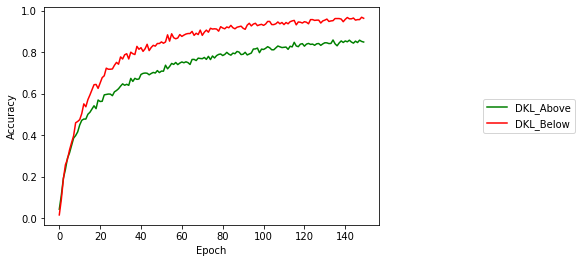

In [15]:
fig1 = plt.figure()


plt.plot(history2.history['accuracy'], color='g')
plt.plot(history.history['accuracy'], color='r')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['DKL_Above','DKL_Below'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig1.savefig('mobilenetv2_hellinger_energy_accuracy_caltech.eps',  dpi=1000, format="eps", bbox_inches="tight") 

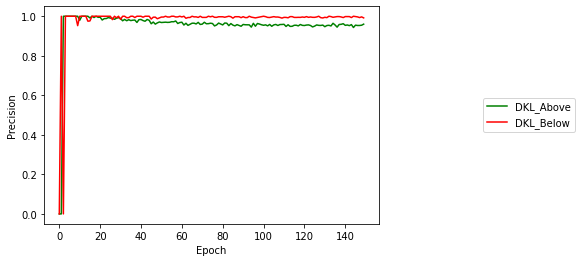

In [16]:
fig1 = plt.figure()
plt.plot(history2.history['precision'], color='g')
plt.plot(history.history['precision'], color='r')

plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['DKL_Above','DKL_Below'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig1.savefig('mobilenetv2_hellinger_energy_precision_caltech.eps',  dpi=1000, format="eps", bbox_inches="tight") 


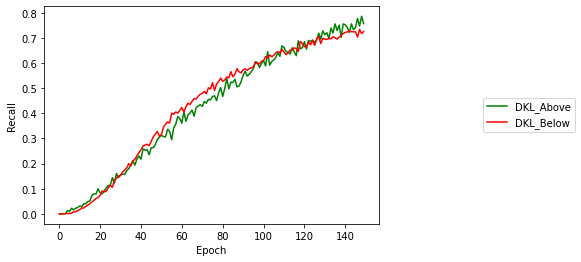

In [17]:
fig1 = plt.figure()


plt.plot(history.history['recall'], color='g')
plt.plot(history2.history['recall'], color='r')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['DKL_Above','DKL_Below'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig1.savefig('mobilenetv2_hellinger_energy_recall_caltech.eps',  dpi=1000, format="eps", bbox_inches="tight") 
